# Predicting childhood asthma with PM 2.5
## Work in progress

To get grounded in a health outcome with a known relationship to air pollution, I'm starting with the relationship between childhood asthma and PM 2.5 (particulate matter smaller than 2.5 microns).

The childhood asthma data comes from the [Western Pennsylvania Regional Data Center](https://data.wprdc.org/dataset/childhood-asthma-healthcare-utilization) (WPRDC) and covers Allegheny County for the year 2017. The data consist of counts of asthma related healthcare encounters over the entire year, as well as the overall number of children, localized by census tract.

The air pollution data comes from the [EPA's Environmental Justice Screen](https://www.epa.gov/ejscreen) [data archive](https://gaftp.epa.gov/EJScreen), as an average annual concentration in mg/m^3 localized by census block group. As documented [here](https://www.epa.gov/system/files/documents/2024-07/ejscreen-tech-doc-version-2-3.pdf), the PM 2.5 concentration estimates are derived from regional monitoring combined with the EPA's Community Multiscale Air Quality (CMAQ) air quality modeling. EJ Screen data also includes demographic information for the census block groups, such as fraction PoC and fraction low income.

Because census tracts are composed of census block groups, it is straightforward to convert the EJ Screen data to localization over census tracts.

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
from libpysal.weights import Queen, KNN
from esda.moran import Moran
import spreg

from air_brain.config import data_dir
from air_brain.tables import ols2df, p_col_style

In [2]:
# census tract geometry
tracts = gpd.read_file(data_dir / "tract_2010" / "tl_2010_42003_tract10.shp")
tracts.GEOID10 = tracts.GEOID10.astype(int)

## Asthma data

The WPRDC childhood asthma dataset includes, for the year 2017 and localized by census tract, counts of the number of children with at least one
- emergency department visit related to asthma `ED_visits`
- hospitalization post-emergency department visit related to asthma `ED_hosp`
- urgent care visit related to asthma `UC_visits`
- medical encounter of any kind related to asthma `Asthma_use`

as well as the total number of children who could have had a recorded medical encounter `Total_members`.

To generate the dependent variables, I divide the encounter counts by the total number of children, to give a fraction of children who have had an asthma-related encounter.

In [3]:
# import the childhood asthma healthcare utilization data
asthma = pd.read_csv(data_dir / "asthma.csv")

# ED hospitalizations should be a subset of ED visits
# so if ED_visits < ED_hosp, set ED_visits to ED_hosp
asthma.loc[asthma.ED_visits < asthma.ED_hosp, "ED_visits"] = asthma.loc[asthma.ED_visits < asthma.ED_hosp, "ED_hosp"]

# convert all counts to fractions of potential patients
for col in ["ED_visits", "ED_hosp", "UC_visits", "Asthma_use"]:
    asthma["{}_frac".format(col)] = asthma[col] / asthma.Total_members
# of children with any asthma related encounter, how many had an emergency/urgent visit?
# if no asthma related encounter, fill with 0
for col in ["ED_visits", "ED_hosp", "UC_visits"]:
    asthma["{}_usefrac".format(col)] = (asthma[col] / asthma.Asthma_use).fillna(0)
# of children with an asthma related ED visit, how many were hospitalized?
# if no asthma related ED visit, fill with 0
asthma["ED_hosp_visitfrac"] = (asthma.ED_hosp / asthma.ED_visits).fillna(0)

dep_vars = ["ED_visits_frac", "ED_hosp_frac", "UC_visits_frac", "Asthma_use_frac",
            "ED_visits_usefrac", "ED_hosp_usefrac", "UC_visits_usefrac",
            "ED_hosp_visitfrac",
           ]

In [4]:
# add on the 2010 census tract geography for plotting
asthma_gpd = tracts.merge(asthma, left_on="GEOID10", right_on="Census_tract", how="right", validate="1:1")

Text(0.5, 1.0, 'Any asthma')

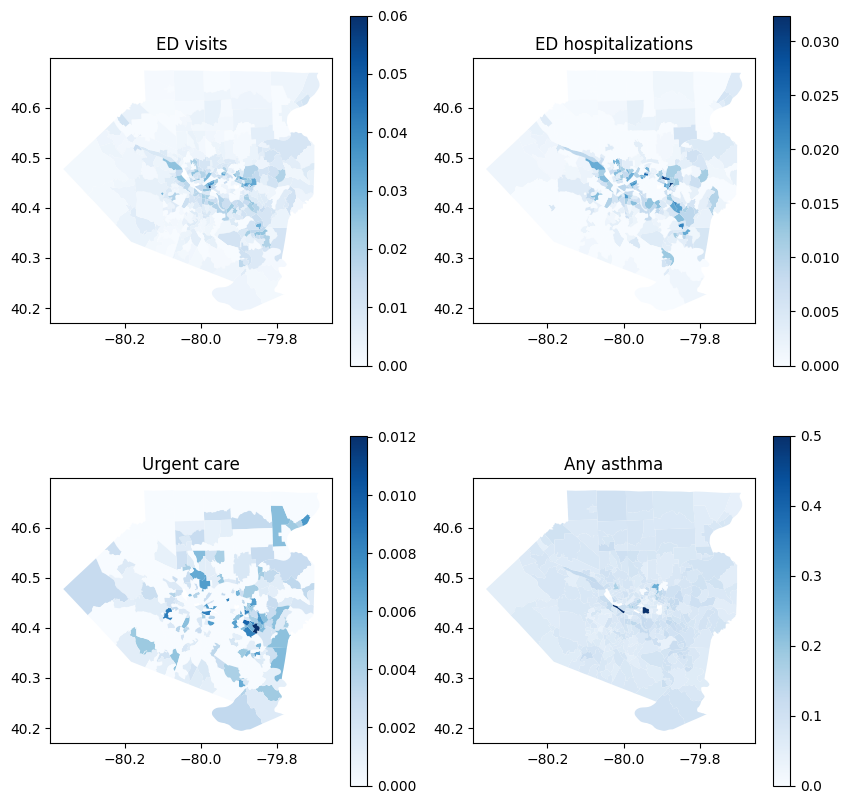

In [5]:
# plot the fraction of children who have at least one asthma encounter types, using Allegheny County geography
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
asthma_gpd.plot(column="ED_visits_frac", cmap="Blues", legend=True, ax=axs[0,0])
axs[0,0].set_title("ED visits")
asthma_gpd.plot(column="ED_hosp_frac", cmap="Blues", legend=True, ax=axs[0,1])
axs[0,1].set_title("ED hospitalizations")
asthma_gpd.plot(column="UC_visits_frac", cmap="Blues", legend=True, ax=axs[1,0])
axs[1,0].set_title("Urgent care")
asthma_gpd.plot(column="Asthma_use_frac", cmap="Blues", legend=True, ax=axs[1,1])
axs[1,1].set_title("Any asthma")

Two thoughts from the initial plots of the asthma data:
- There is a tempting pattern of higher asthma encounters in the southeast region of Allegheny County. Is this statistically significant? We'll find out! (Yes, it is.)
- There are two (possibly three) apparent outlier census tracts among the counts of any medical encounter for asthma.

Text(0.5, 1.0, 'Any asthma')

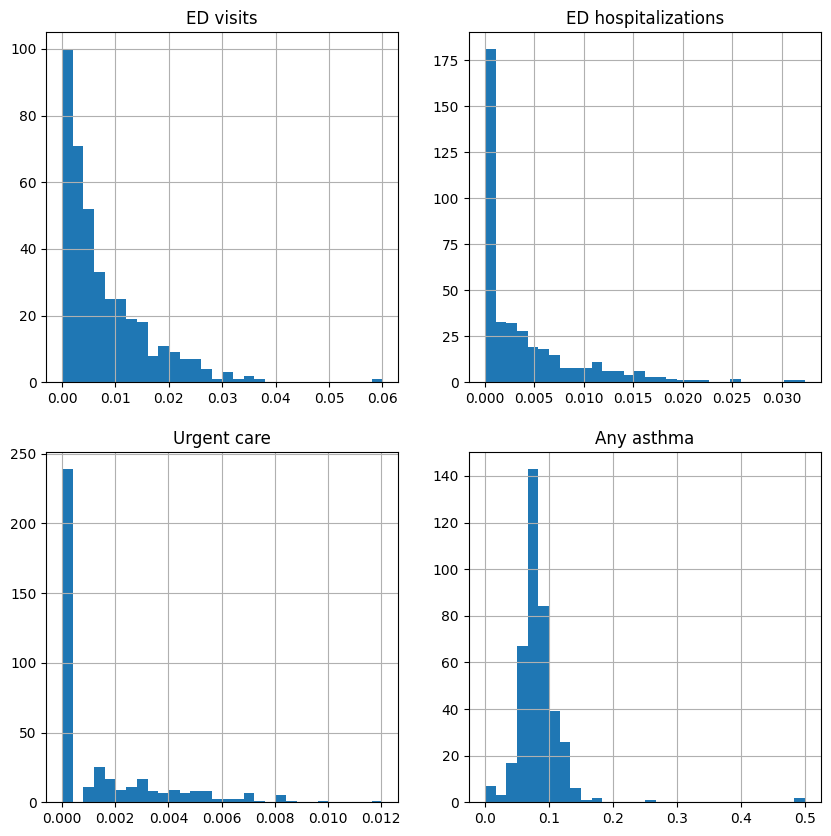

In [6]:
# histograms of asthma data to inspect for outliers
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
asthma["ED_visits_frac"].hist(bins=30, ax=axs[0,0])
axs[0,0].set_title("ED visits")
asthma["ED_hosp_frac"].hist(bins=30, ax=axs[0,1])
axs[0,1].set_title("ED hospitalizations")
asthma["UC_visits_frac"].hist(bins=30, ax=axs[1,0])
axs[1,0].set_title("Urgent care")
asthma["Asthma_use_frac"].hist(bins=30, ax=axs[1,1])
axs[1,1].set_title("Any asthma")

From the histogram, it looks like there are 3 outlier census tracts, where the fraction of use is above 0.2.

In [7]:
# TODO z-score / other statistical outlier detection

In [8]:
# what else do we know about these census tracts?
asthma.loc[asthma.Asthma_use_frac > 0.2]

,Census_tract,ED_visits,ED_hosp,UC_visits,Asthma_use,Total_members,ED_visits_frac,ED_hosp_frac,UC_visits_frac,Asthma_use_frac,ED_visits_usefrac,ED_hosp_usefrac,UC_visits_usefrac,ED_hosp_visitfrac
389,42003980100,0,0,0,1,4,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0
392,42003980500,0,0,0,2,4,0.0,0.0,0.0,0.50,0.0,0.0,0.0,0.0
394,42003980700,0,0,0,1,2,0.0,0.0,0.0,0.50,0.0,0.0,0.0,0.0


<Axes: >

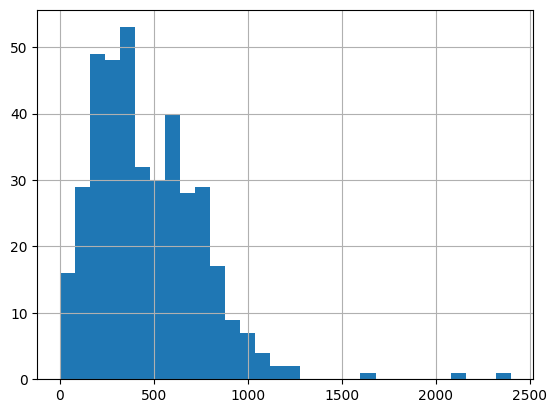

In [9]:
asthma.Total_members.hist(bins=30)

These census tracts have very few total children who could have received documented medical encounters `Total_members`, so it makes sense that they are outliers. From the histogram above, we see that most census tracts have at least 100 total children.

As a final check of the asthma data, I want to look at the general asthma encounter rates without the effect of the outliers.

<Axes: >

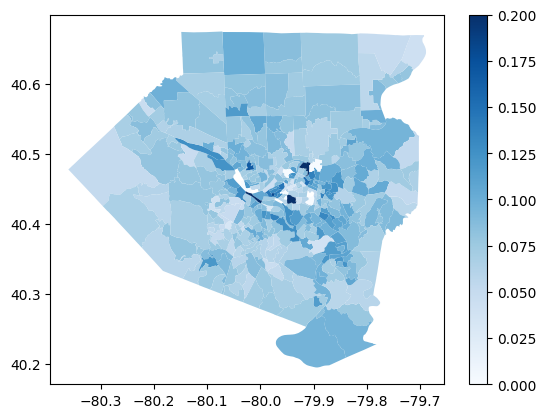

In [10]:
asthma_gpd.plot(column="Asthma_use_frac", cmap="Blues", legend=True, vmax=0.2)

There is less of a visible spatial pattern in general asthma use, compared to urgent care or emergency department use.

## Air quality and demographics

The EPA's EJ Screen dataset includes PM 2.5 concentration estimations averaged annually and over census block groups. Census tracts are composed of unions of census block groups, so it is straightforward to average the PM 2.5 concentrations over census tracts to match the localization of the asthma data.

The EJ Screen data includes several variables related to air quality, including
- PM 2.5 `PM25`
- ozone `O3`
- TODO nitrogen dioxide
- diesel particulate matter `dpm`
- traffic proximity `traffic`
- TODO toxic releases to air

I am also using the EPA's demographic data, specifically
- fraction of residents who are low income, i.e. within 2x of the federal poverty line `lowincome`
- fraction of residents who are people of color `poc`
  
This demographic data is compiled by the EPA from the American Community Survey (ACS).

In [11]:
# import the EPA's air quality and demographic data
aq = pd.read_csv(data_dir  / "epa_ej" / "2017_tract.csv")

In [12]:
# add on the 2010 census tract geography for plotting
aq_gpd = tracts.merge(aq, left_on="GEOID10", right_on="ID", how="right", validate="1:1")

Text(0.5, 1.0, 'Traffic')

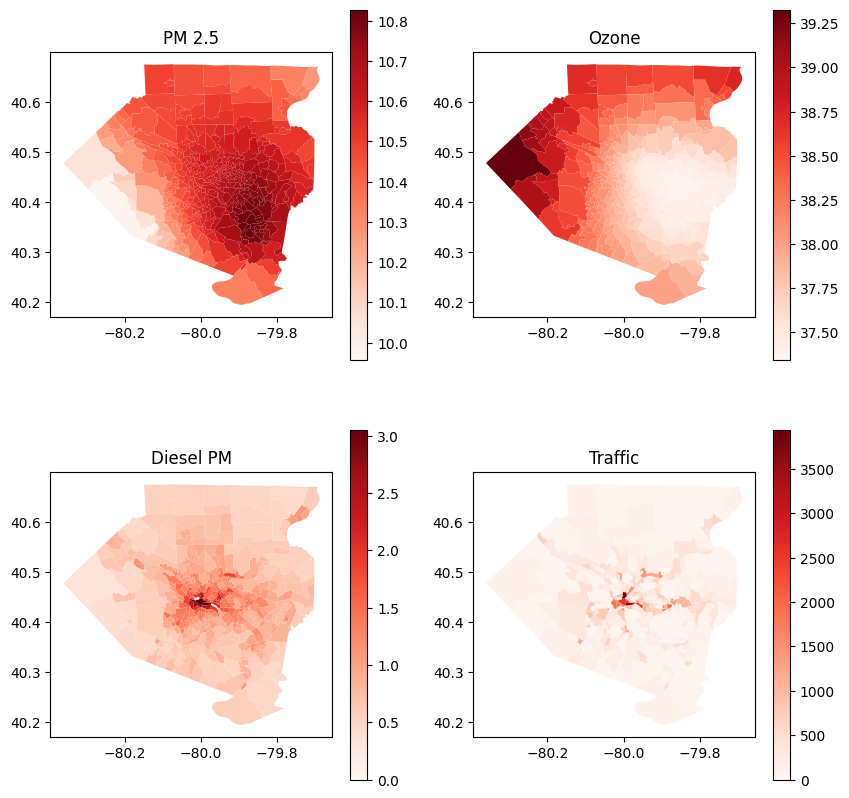

In [13]:
# plots of air quality related measures
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
aq_gpd.plot(column="PM25", cmap="Reds", legend=True, ax=axs[0,0])
axs[0,0].set_title("PM 2.5")
aq_gpd.plot(column="O3", cmap="Reds", legend=True, ax=axs[0,1])
axs[0,1].set_title("Ozone")
aq_gpd.plot(column="dpm", cmap="Reds", legend=True, ax=axs[1,0])
axs[1,0].set_title("Diesel PM")
aq_gpd.plot(column="traffic", cmap="Reds", legend=True, ax=axs[1,1])
axs[1,1].set_title("Traffic")

- There seems to be a higher concentration of PM 2.5 in the southeastern portion of Allegheny County. This matches the apparent higher rates of asthma related encounters seen above.
- It looks like there is an inverse relationship between PM 2.5 and ozone in Allegheny County, at least in 2017. This is somewhat surprising, potentially related to PM 2.5 reducing solar radiation and therefore ozone production, and out of the scope of this analysis.
- Diesel PM and traffic proximity seem to be concentrated near downtown Pittsburgh.

Text(0.5, 1.0, 'People of color')

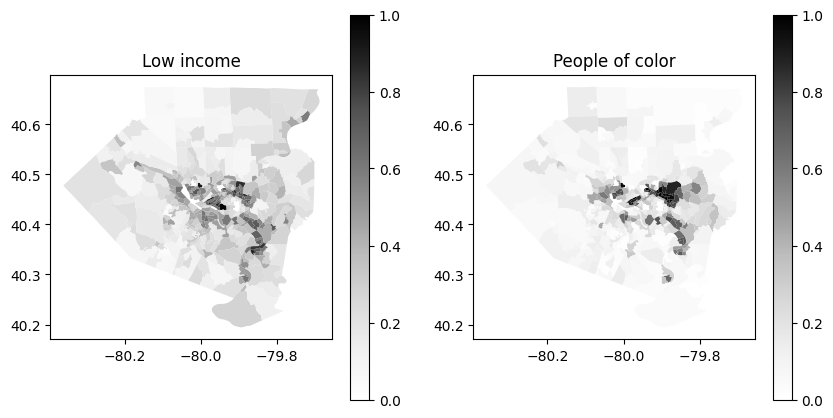

In [14]:
# plots of demographic measures
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
aq_gpd.plot(column="lowincome", cmap="Greys", legend=True, ax=axs[0])
axs[0].set_title("Low income")
aq_gpd.plot(column="poc", cmap="Greys", legend=True, ax=axs[1])
axs[1].set_title("People of color")

- Southeastern Allegheny County appears to have more residents who are low income, as well as more residents who are people of color.

## Asthma vs PM 2.5

In [15]:
# merge asthma data with air quality / demographic data
df = asthma.merge(aq, left_on="Census_tract", right_on="ID", how="left", validate="1:1")
# put the geometry back in
df = tracts.merge(df, right_on="Census_tract", left_on="GEOID10", validate="1:1")

In [16]:
# TODO less hokey exploratory plots

Text(0.5, 1.0, 'Any asthma')

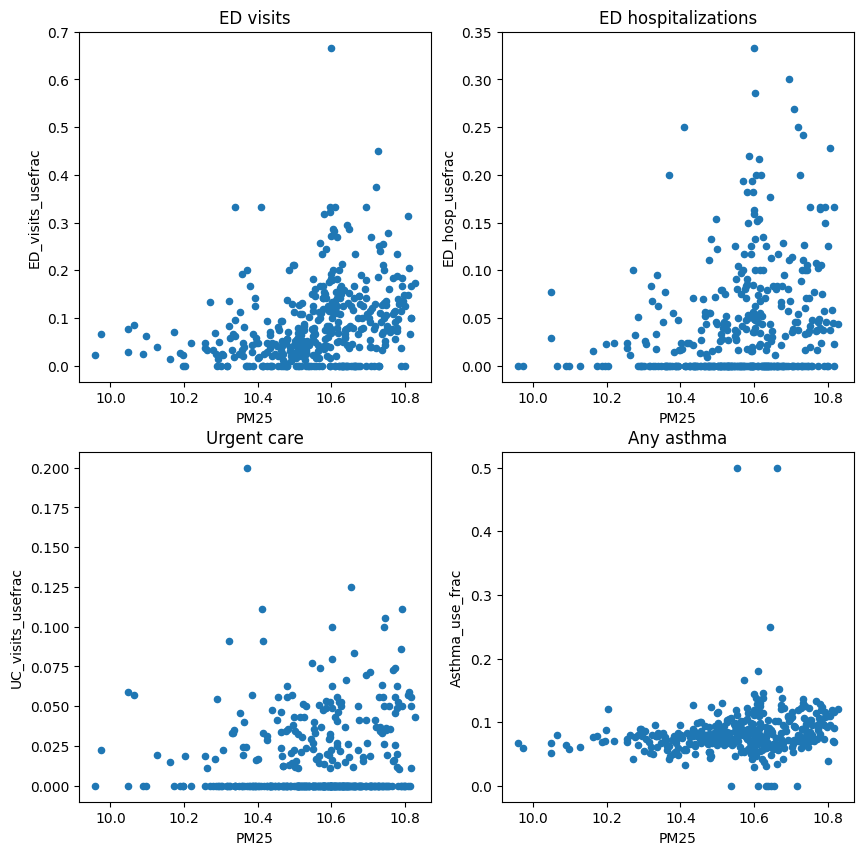

In [17]:
# scatterplots of PM 2.5 vs asthma encounter fractions
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
df.plot(x="PM25", y="ED_visits_usefrac", kind="scatter", ax=axs[0,0])
axs[0,0].set_title("ED visits")
df.plot(x="PM25", y="ED_hosp_usefrac", kind="scatter", ax=axs[0,1])
axs[0,1].set_title("ED hospitalizations")
df.plot(x="PM25", y="UC_visits_usefrac", kind="scatter", ax=axs[1,0])
axs[1,0].set_title("Urgent care")
df.plot(x="PM25", y="Asthma_use_frac", kind="scatter", ax=axs[1,1])
axs[1,1].set_title("Any asthma")

- The scatterplots of PM 2.5 vs asthma encounter fractions show a plausible positive relationship between the pairs of variables.
- The outlier points for any asthma encounter are for census tracts with high PM 2.5. This indicates that removing these points would weaken any positive correlation between PM 2.5 and general asthma encounters, so removing the points is expected to result in a more conservative analysis.

For visual reference, I also include the scatterplot of general asthma encounters without the outliers.

<Axes: xlabel='PM25', ylabel='Asthma_use_frac'>

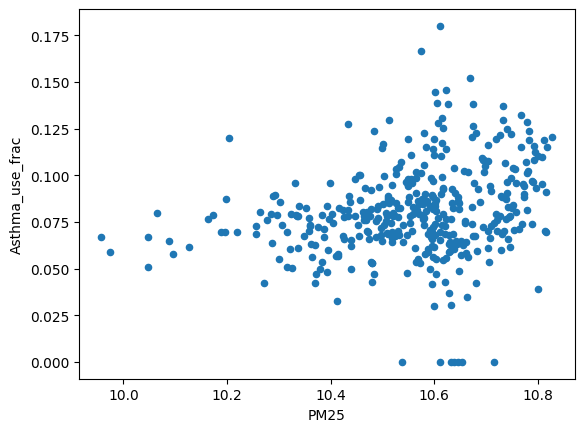

In [18]:
df_rmout = df.loc[df.Asthma_use_frac < 0.2].copy()
df_rmout.plot(x="PM25", y="Asthma_use_frac", kind="scatter")

### Without controlling for demographics

In [19]:
# linear regression, predicting asthma encounter fraction using average PM 2.5 concentration as sole predictor
ols_res = dict()
for col in dep_vars:
    mod = sm.OLS(df[col], df[["PM25"]])
    res = mod.fit()
    ols_res[col] = res
ols2df(ols_res)[["coef", "std err", "p"]].style.pipe(p_col_style)

,,coef,std err,p
dep_var,indep_var,,,
ED_visits_frac,PM25,0.000731,0.000038,0.000
ED_hosp_frac,PM25,0.000365,0.000026,0.000
UC_visits_frac,PM25,0.000131,0.000010,0.000
Asthma_use_frac,PM25,0.007887,0.000187,0.000
ED_visits_usefrac,PM25,0.008345,0.000400,0.000
ED_hosp_usefrac,PM25,0.004116,0.000282,0.000
UC_visits_usefrac,PM25,0.001553,0.000124,0.000
ED_hosp_visitfrac,PM25,0.034464,0.001796,0.000


If I only consider PM 2.5 as a predictor, linear regression shows a significant relationship between PM 2.5 and asthma encounter fractions for all encounter types.

Do these relationships stand up to controlling for demographic covariates?

### Controlling for demographics

In [20]:
# linear regression, predicting asthma encounter fraction using average PM 2.5 concentration as well as demographics
ols_res = dict()
for col in dep_vars:
    mod = sm.OLS(df[col], df[["PM25", "lowincome", "poc"]])
    res = mod.fit()
    ols_res[col] = res
ols2df(ols_res)[["coef", "std err", "p"]].style.pipe(p_col_style)

For emergency department visits and hospitalizations, PM 2.5 is no longer a significant predictor when low income and PoC covariates are included. However, higher fractions of both low income and PoC residents predict higher rates of emergency department utilization for childhood asthma. I believe this result reflects that lower income residents and PoC residents have less access to non-emergency medical services than higher income and white residents. These residents therefore are more likely to be seen in the emergency department rather than urgent or primary care. They may have higher rates of ED hospitalization due to lack of access to preventative care leading to higher acuity cases.

PM 2.5 remains a significant predictor of urgent care visits as well as overall medical encounters related to childhood asthma. In areas with higher average annual concentrations of PM 2.5, a higher fraction of children receive medical attention for asthma, even when controlling for low income and PoC resident proportions. 

### Spatial autocorrelation

The linear regressions above assume that observations are independent of each other. However, I have good reason to believe that they are not, since there are apparent spatial structures in the variables. Particularly for PM 2.5, I would be suprised if there wasn't spatial autocorrelation in the data: areas close to each other are expected to have more similar air than areas further away.

I first want to determine, statistically, if our variables are spatially autocorrelated. I will use Moran's I, with Queen's contiguity as weights.

TODO is this better than just using Geary??? could do either

In [21]:
# spatial lag weights from Queen's contiguity
w = Queen.from_dataframe(df, use_index=False)
# standardize by rows
w.transform = "R"
# compute Moran's I
res_dict = {}
for col in ["PM25", "lowincome", "poc"] + dep_vars:
    moran = Moran(df[col], w)
    res_dict[col] = {"I": moran.I, "p": moran.p_sim}
res = pd.DataFrame(res_dict).transpose()
res

,I,p
PM25,0.957032,0.001
lowincome,0.540981,0.001
poc,0.640654,0.001
ED_visits_frac,0.406188,0.001
ED_hosp_frac,0.308959,0.001
UC_visits_frac,0.141179,0.001
Asthma_use_frac,0.040995,0.054
ED_visits_usefrac,0.283705,0.001
ED_hosp_usefrac,0.249285,0.001
UC_visits_usefrac,0.058279,0.028


All 3 of the predictors, and all the outcomes except for overall asthma use, are significantly spatially autocorrelated.

- In the predictors/independent variables, autocorrelation may lead to underestimation of coefficient confidence intervals, causing predictors to appear significant that actually aren't. I am in esssence "double counting" the effect of each autocorrelated predictor, because measurements from adjacent census tracts are similar to each other.
- Autocorrelation of the outcomes/dependent variables may lead to a biased (aka just plain wrong) estimates of model coefficients.
- For both types of variables, I also want to know if there is a spatial structure to the model residuals. Does the model work better in different areas of Allegheny County? Do my conclusions about the significance of different predictors only actually apply in specific regions? TODO

One way to handle spatial autocorrelation is to include spatial lag in the model formulation. There are several common ways of incorporating spatial lag:
- TODO Include pre-computed spatial lags of the independent variables in the linear regression (for independent variable spatial autocorrelation)
- Include spatial lag in the error term of the linear regression (for independent variable spatial autocorrelation)
- Include spatial lag of the dependent variable in the linear regression (for dependent variable spatial autocorrelation)

TODO what about both independent and dependent variables?

In [49]:
def spreg2df(spreg_res, name_attr="name_x"):
    """
    utility to generate a dataframe of results from a dict of spreg fit outputs

    spreg_res: dict with str keys (name of dependent variable) and spreg fit
    """
    dfs = []
    for col, res in spreg_res.items():
        res_df = pd.DataFrame({"coef": res.betas.flatten(), "std err": res.std_err.flatten(),
                               "p": [i[1] for i in res.z_stat]}, index=getattr(res, name_attr))
        res_df.drop("CONSTANT", inplace=True)
        res_df["dep_var"] = col
        dfs.append(res_df)
    df = pd.concat(dfs)

    # reset index
    df.reset_index(inplace=True, names="indep_var")
    df.set_index(["dep_var", "indep_var"], inplace=True)

    return df

In [48]:
# Spatial lag in the error term, fit using
# general method of moments estimation allowing for heteroskedasticity
#
# This is a general method that allows us to choose the weights used to compute the error term, 
# in this case the same spatial lag weights computed above

# start without controlling for demographics
indep = ["PM25"]
res_dict = dict()
for dep in dep_vars:
    res = spreg.GM_Error_Het(df[[dep]].values, df[indep].values, w=w, name_y=dep, name_x=indep)
    res_dict[dep] = res
spreg2df(res_dict)[["coef", "std err", "p"]].style.pipe(p_col_style)

As before, PM 2.5 is a significant predictor of all measures of childhood asthma, even accounting for the effect of spatial autocorrelation in PM 2.5.

The spatial lag error term coefficient `lambda` is also significant for every model except when predicting overall asthma use. The p-values for the PM 2.5 coefficient are also much larger. This suggests that the spatial autocorrelation of PM 2.5 did cause underestimation of the confidence intervals in the previous models.

How do these effects hold up to controlling for demographic covariates?

In [33]:
indep = ["PM25", "lowincome", "poc"]
res_dict = dict()
for dep in dep_vars:
    res = spreg.GM_Error_Het(df[[dep]].values, df[indep].values, w=w, name_y=dep, name_x=indep)
    res_dict[dep] = res
spreg2df(res_dict)[["coef", "std err", "p"]].style.pipe(p_col_style)

Not very well! PM 2.5 loses significance as a predictor for all measures of childhood asthma, although its p value is under 0.1 for three out of four dependent variables. The spatial lag term `lambda` is significant for emergency department and urgent care visits.

Recall that for the original models (without spatial lag), only the urgent care visits and overall asthma use remained significant after controlling for demographics.

What about if we control for spatial autocorrelation in the dependent variables?

In [50]:
# Spatial lag in the dependent variable, fit using
# general method of moments estimation allowing for dependent variable lag
#
# This is a general method that allows us to choose the weights used to lag the dependent variable,
# in this case the same spatial lag weights computed above

# start without controlling for demographics
indep = ["PM25"]
res_dict = dict()
for dep in dep_vars:
    res = spreg.GM_Lag(df[[dep]].values, df[indep].values, w=w, name_y=dep, name_x=indep)
    res_dict[dep] = res
spreg2df(res_dict, name_attr="name_z")[["coef", "std err", "p"]].style.pipe(p_col_style)

                      coef   std err         p             dep
CONSTANT         -0.289746  0.228625  0.205033  ED_visits_frac
PM25              0.028620  0.022589  0.205167  ED_visits_frac
W_ED_visits_frac -0.636452  1.333917  0.633269  ED_visits_frac
                    coef   std err         p           dep
CONSTANT       -0.118557  0.189181  0.530865  ED_hosp_frac
PM25            0.011631  0.018603  0.531821  ED_hosp_frac
W_ED_hosp_frac -0.111074  1.937561  0.954285  ED_hosp_frac
                      coef   std err         p             dep
CONSTANT         -0.010136  0.018550  0.584781  UC_visits_frac
PM25              0.001011  0.001842  0.583092  UC_visits_frac
W_UC_visits_frac  0.615075  0.718185  0.391760  UC_visits_frac
                       coef   std err         p              dep
CONSTANT          -0.312732  1.584256  0.843515  Asthma_use_frac
PM25               0.035915  0.185141  0.846186  Asthma_use_frac
W_Asthma_use_frac  0.198939  4.422068  0.964117  Asthma_use_frac


In [51]:
indep = ["PM25", "lowincome", "poc"]
res_dict = dict()
for dep in dep_vars:
    res = spreg.GM_Lag(df[[dep]].values, df[indep].values, w=w, name_y=dep, name_x=indep)
    res_dict[dep] = res
spreg2df(res_dict, name_attr="name_z")[["coef", "std err", "p"]].style.pipe(p_col_style)